Portfolio Project: Identify Water Bodies from Sentinel-2 using Machine Learning

In [61]:
#Import Packages

import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
import rioxarray
from rasterio.plot import show
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from xgboost import XGBClassifier

In [2]:
#Import training dataset

input_path = r"H:\AfifBelajar\Water Bodies\Train_data_v6.geojson"
train = gpd.read_file(input_path)
train.head()

,id,class,B_1,B_2,B_3,B_4,geometry
0,1,1,0.0940,0.0799,0.0545,0.0569,POINT (709306.173 9286047.887)
1,2,1,0.0948,0.0791,0.0531,0.0482,POINT (709300.797 9286053.086)
2,3,1,0.0919,0.0727,0.0499,0.0449,POINT (709263.861 9286259.375)
3,4,1,0.0926,0.0741,0.0509,0.0704,POINT (709296.699 9286283.207)
4,5,1,0.0942,0.0756,0.0545,0.0941,POINT (709280.549 9286256.067)


In [3]:
#Remame training dataset
train.rename(columns={'B_1': 'B_2', 'B_2': 'B_3', 'B_3': 'B_4', 'B_4': 'B_8'}, inplace=True)
train

,id,class,B_2,B_3,B_4,B_8,geometry
0,1,1,0.0940,0.0799,0.0545,0.0569,POINT (709306.173 9286047.887)
1,2,1,0.0948,0.0791,0.0531,0.0482,POINT (709300.797 9286053.086)
2,3,1,0.0919,0.0727,0.0499,0.0449,POINT (709263.861 9286259.375)
3,4,1,0.0926,0.0741,0.0509,0.0704,POINT (709296.699 9286283.207)
4,5,1,0.0942,0.0756,0.0545,0.0941,POINT (709280.549 9286256.067)
...,...,...,...,...,...,...,...
7753,7754,1,0.0931,0.0809,0.0523,0.1373,POINT (707478.348 9285798.989)
7754,7755,1,0.0951,0.0843,0.0570,0.1851,POINT (707401.416 9285811.46)
7755,7756,1,0.0916,0.0752,0.0473,0.0750,POINT (707454.919 9285822.518)
7756,7757,1,0.0981,0.0862,0.0609,0.1435,POINT (707442.283 9285813.977)


In [4]:
#Calculate NDWI and NDVI
train['NDWI']=(train['B_3'] - train['B_8']) / (train['B_3'] + train['B_8'])
train['NDVI']=(train['B_8'] - train['B_4']) / (train['B_8'] + train['B_4'])
train.head(10)

,id,class,B_2,B_3,B_4,B_8,geometry,NDWI,NDVI
0,1,1,0.0940,0.0799,0.0545,0.0569,POINT (709306.173 9286047.887),0.168129,0.021544
1,2,1,0.0948,0.0791,0.0531,0.0482,POINT (709300.797 9286053.086),0.242734,-0.048371
2,3,1,0.0919,0.0727,0.0499,0.0449,POINT (709263.861 9286259.375),0.236395,-0.052743
3,4,1,0.0926,0.0741,0.0509,0.0704,POINT (709296.699 9286283.207),0.025606,0.160758
4,5,1,0.0942,0.0756,0.0545,0.0941,POINT (709280.549 9286256.067),-0.109016,0.266487
5,6,1,0.0947,0.0804,0.0530,0.0521,POINT (709343.933 9285996.699),0.213585,-0.008563
6,7,1,0.0936,0.0742,0.0500,0.0435,POINT (709262.962 9286354.844),0.260833,-0.069519
7,8,1,0.0937,0.0773,0.0530,0.0676,POINT (709234.959 9286261.413),0.066943,0.121061
8,9,1,0.0962,0.0832,0.0545,0.1110,POINT (709339.393 9285992.793),-0.143151,0.341390
9,10,1,0.0948,0.0772,0.0527,0.0428,POINT (709248.075 9286080.155),0.286667,-0.103665


In [5]:
#Clean dataset with nan
train=train.dropna()
train.head()

,id,class,B_2,B_3,B_4,B_8,geometry,NDWI,NDVI
0,1,1,0.0940,0.0799,0.0545,0.0569,POINT (709306.173 9286047.887),0.168129,0.021544
1,2,1,0.0948,0.0791,0.0531,0.0482,POINT (709300.797 9286053.086),0.242734,-0.048371
2,3,1,0.0919,0.0727,0.0499,0.0449,POINT (709263.861 9286259.375),0.236395,-0.052743
3,4,1,0.0926,0.0741,0.0509,0.0704,POINT (709296.699 9286283.207),0.025606,0.160758
4,5,1,0.0942,0.0756,0.0545,0.0941,POINT (709280.549 9286256.067),-0.109016,0.266487


Text(0.5, 1.0, 'Distribution of Class Columns: ')

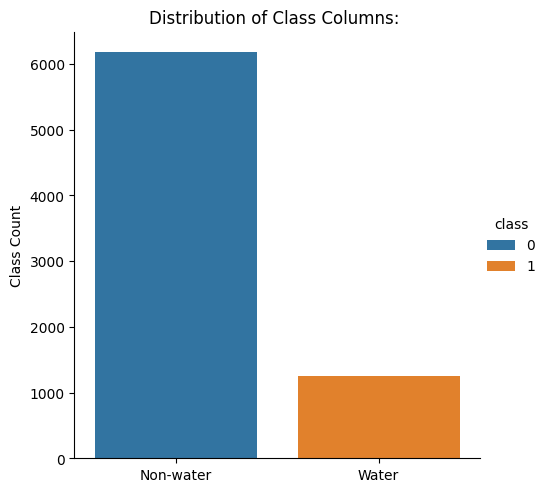

In [6]:
#Data Distribution checking
g=sns.catplot(data=train, x="class", hue="class", kind="count")
g.set_axis_labels("", "Class Count")
g.set_xticklabels(["Non-water", "Water"])
plt.title("Distribution of Class Columns: ")

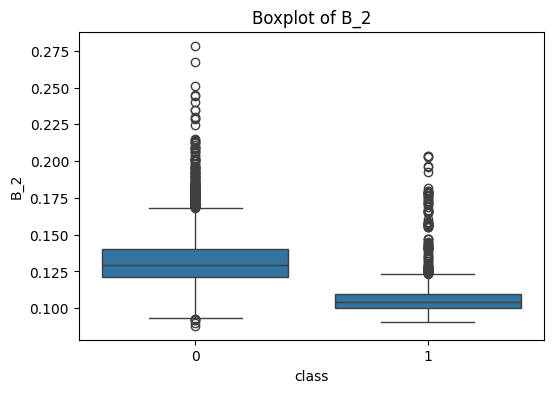

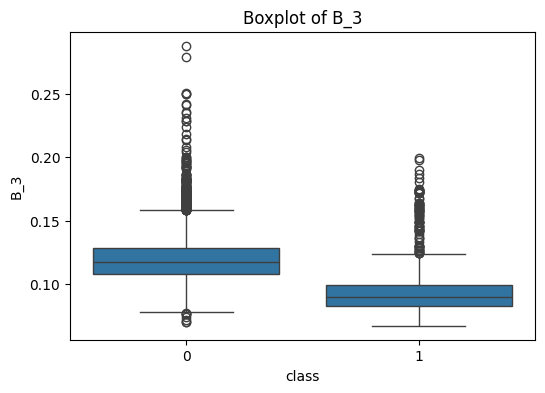

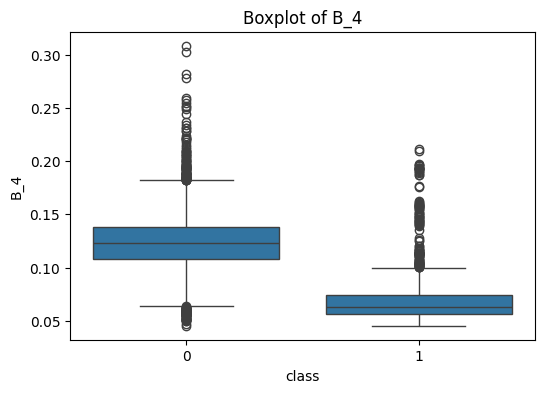

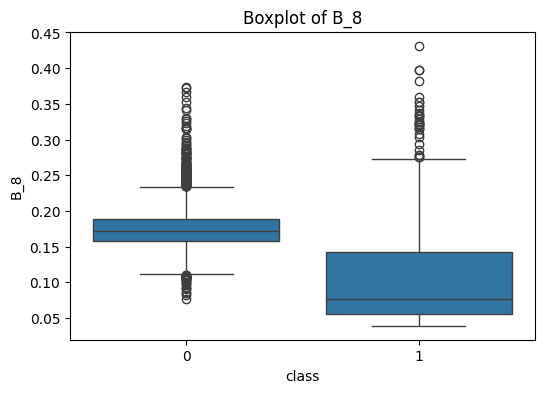

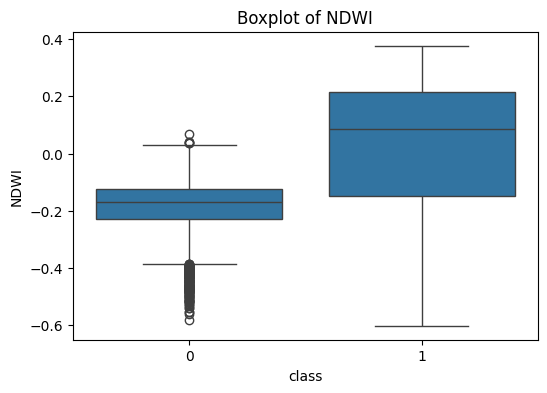

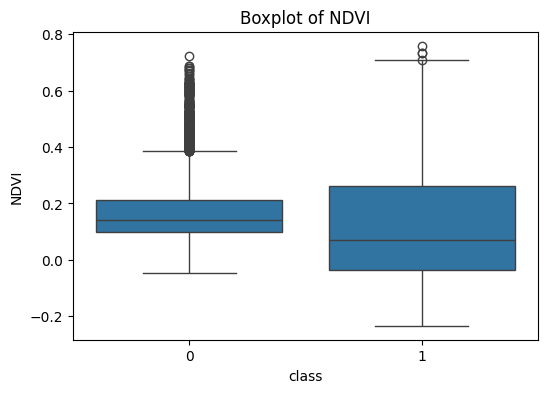

In [10]:
# Create Boxplots for each column by class
for col in train.select_dtypes(include=['int64', 'float64']).columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='class', y=col, data=train)
    plt.title(f'Boxplot of {col}')
    plt.show()

In [7]:
#Import test dataset
test_path = r"H:\AfifBelajar\Water Bodies\Test_data_v6.geojson"
test = gpd.read_file(test_path)
test.head()

,id,class,B_1,B_2,B_3,B_4,geometry
0,2,0,0.1015,0.0908,0.0691,0.2219,POINT (696271.763 9282547.116)
1,9,0,0.1177,0.1021,0.0941,0.1753,POINT (696113.535 9282703.363)
2,23,0,0.1387,0.1198,0.1181,0.1690,POINT (695807.579 9282423.856)
3,91,1,NaN,NaN,NaN,NaN,None
4,93,1,NaN,NaN,NaN,NaN,None


In [8]:
#Rename test dataset
test.rename(columns={'B_1': 'B_2', 'B_2': 'B_3', 'B_3': 'B_4', 'B_4': 'B_8'}, inplace=True)
test

,id,class,B_2,B_3,B_4,B_8,geometry
0,2,0,0.1015,0.0908,0.0691,0.2219,POINT (696271.763 9282547.116)
1,9,0,0.1177,0.1021,0.0941,0.1753,POINT (696113.535 9282703.363)
2,23,0,0.1387,0.1198,0.1181,0.1690,POINT (695807.579 9282423.856)
3,91,1,NaN,NaN,NaN,NaN,None
4,93,1,NaN,NaN,NaN,NaN,None
...,...,...,...,...,...,...,...
4142,75502,0,0.1230,0.1095,0.0978,0.1841,POINT (695421.98 9279691.321)
4143,75523,0,0.1088,0.0991,0.0896,0.1704,POINT (696051.987 9279852.976)
4144,75527,0,0.1178,0.1061,0.1003,0.1480,POINT (695964.817 9279862.646)
4145,75554,0,0.1275,0.1144,0.1174,0.1824,POINT (695639.762 9279205.916)


In [9]:
#Calculate NDWI and NDVI
test['NDWI']=(test['B_3'] - test['B_8']) / (test['B_3'] + test['B_8'])
test['NDVI']=(test['B_8'] - test['B_4']) / (test['B_8'] + test['B_4'])
test.head()

,id,class,B_2,B_3,B_4,B_8,geometry,NDWI,NDVI
0,2,0,0.1015,0.0908,0.0691,0.2219,POINT (696271.763 9282547.116),-0.419252,0.525086
1,9,0,0.1177,0.1021,0.0941,0.1753,POINT (696113.535 9282703.363),-0.263879,0.301411
2,23,0,0.1387,0.1198,0.1181,0.1690,POINT (695807.579 9282423.856),-0.170360,0.177290
3,91,1,NaN,NaN,NaN,NaN,None,NaN,NaN
4,93,1,NaN,NaN,NaN,NaN,None,NaN,NaN


In [10]:
#Check if data has Nan
test.isna()

,id,class,B_2,B_3,B_4,B_8,geometry,NDWI,NDVI
0,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False
3,False,False,True,True,True,True,True,True,True
4,False,False,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...
4142,False,False,False,False,False,False,False,False,False
4143,False,False,False,False,False,False,False,False,False
4144,False,False,False,False,False,False,False,False,False
4145,False,False,False,False,False,False,False,False,False


In [11]:
#Clean data with nan
test.dropna(how='any', inplace=True)
test.head()

,id,class,B_2,B_3,B_4,B_8,geometry,NDWI,NDVI
0,2,0,0.1015,0.0908,0.0691,0.2219,POINT (696271.763 9282547.116),-0.419252,0.525086
1,9,0,0.1177,0.1021,0.0941,0.1753,POINT (696113.535 9282703.363),-0.263879,0.301411
2,23,0,0.1387,0.1198,0.1181,0.1690,POINT (695807.579 9282423.856),-0.170360,0.177290
13,140,1,0.1092,0.0952,0.0732,0.1115,POINT (704387.181 9284368.671),-0.078858,0.207363
14,141,1,0.1012,0.0870,0.0595,0.0530,POINT (704384.319 9284412.393),0.242857,-0.057778


In [12]:
#Split x and Y features in dataset
X_train=train[['B_2', 'B_3', 'B_4','B_8', 'NDWI','NDVI']]
y_train=train['class']
X_test=test[['B_2', 'B_3', 'B_4','B_8', 'NDWI','NDVI']]
y_test=test['class']

In [83]:
# create model
rf = RandomForestClassifier() #random forest
xgb = XGBClassifier() #Xgboost
lr = LogisticRegression() #logistic regression
svm = svm.SVC(kernel='linear') #support vector machine

# fit model
rf.fit(X_train, y_train)
lr.fit(X_train, y_train)
xgb.fit(X_train, y_train)
svm.fit(X_train, y_train)

SVC(kernel='linear')

In [71]:
#Cross validation in each model
cv_results_rf = cross_validate(rf, X_train, y_train, cv=5)
cv_results_xgb = cross_validate(lr, X_train, y_train, cv=5)
cv_results_lr = cross_validate(xgb, X_train, y_train, cv=5)
#cv_results_svm = cross_validate(svm, X_train, y_train, cv=5)

print(f"CV Result Random Forest : {cv_results_rf['test_score'].mean()}")
print(f"CV Result XGBoost : {cv_results_xgb['test_score'].mean()}")
print(f"CV Result Logistic Regression : {cv_results_lr['test_score'].mean()}")
#print(f"CV Result Support Vector Machine : {cv_results_svm['test_score'].mean()}")

CV Result Random Forest : 0.9585820841558743
CV Result XGBoost : 0.9484963772045903
CV Result Logistic Regression : 0.9584474947755096


In [31]:
#Model Prediction to test dataset
models={'Random Forest':rf,'Logistic Regression':lr,'XGBoost':xgb,'Support Vector Machine':svm}

result=[]

for model in models.items():
    y_pred=model[1].predict(X_test)
    acc=accuracy_score(y_test, y_pred)
    f1=f1_score(y_test, y_pred)

    result.append({'Model': model[0], 'Accuracy': acc, 'F1 Score': f1})

result_df = pd.DataFrame(result)
print(result_df)

                    Model  Accuracy  F1 Score
0           Random Forest  0.947599  0.856571
1     Logistic Regression  0.923471  0.763554
2                 XGBoost  0.948330  0.861799
3  Support Vector Machine  0.928345  0.781250


In [32]:
#Open wall to wall dataset
with rasterio.open(r"H:\AfifBelajar\Water Bodies\test_sat_w2w.tif") as src:
    # Get the transform to convert pixel coordinates to geographic coordinates
    transform = src.transform
    
    # Get the raster dimensions
    height = src.height
    width = src.width
    
    # Generate arrays of pixel coordinates
    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    
    # Convert pixel coordinates to geographic coordinates
    xs, ys = rasterio.transform.xy(transform, rows, cols)
    
    # Read the raster values (assuming single band)
    array = src.read()
    
    # Flatten all arrays and create DataFrame
    w2w = pd.DataFrame({
        'x': np.array(xs).ravel(),
        'y': np.array(ys).ravel(),
    })
    
    w2w['B_2'] = array[0].ravel() 
    w2w['B_3'] = array[1].ravel()
    w2w['B_4'] = array[2].ravel() 
    w2w['B_8'] = array[3].ravel() 

# Display the first few rows
w2w.head()

,x,y,B_2,B_3,B_4,B_8
0,699298.519972,9.285245e+06,0.1235,0.1093,0.1132,0.1957
1,699309.833725,9.285245e+06,0.1162,0.1107,0.0990,0.2093
2,699321.147479,9.285245e+06,0.1511,0.1438,0.1576,0.2101
3,699332.461232,9.285245e+06,0.1325,0.1254,0.1240,0.1816
4,699343.774986,9.285245e+06,0.1160,0.0994,0.1012,0.1540


In [33]:
#Calculate NDWI and NDVI
w2w['NDWI']=(w2w['B_3'] - w2w['B_8']) / (w2w['B_3'] + w2w['B_8'])
w2w['NDVI']=(w2w['B_8'] - w2w['B_4']) / (w2w['B_8'] + w2w['B_4'])
w2w

,x,y,B_2,B_3,B_4,B_8,NDWI,NDVI
0,699298.519972,9.285245e+06,0.1235,0.1093,0.1132,0.1957,-0.283279,0.267077
1,699309.833725,9.285245e+06,0.1162,0.1107,0.0990,0.2093,-0.308125,0.357768
2,699321.147479,9.285245e+06,0.1511,0.1438,0.1576,0.2101,-0.187341,0.142779
3,699332.461232,9.285245e+06,0.1325,0.1254,0.1240,0.1816,-0.183062,0.188482
4,699343.774986,9.285245e+06,0.1160,0.0994,0.1012,0.1540,-0.215470,0.206897
...,...,...,...,...,...,...,...,...
491035,709198.054337,9.279032e+06,0.0908,0.0864,0.0570,0.2789,-0.526964,0.660613
491036,709209.368090,9.279032e+06,0.0873,0.0800,0.0517,0.2386,-0.497803,0.643817
491037,709220.681844,9.279032e+06,0.0891,0.0793,0.0512,0.3224,-0.605178,0.725910
491038,709231.995597,9.279032e+06,0.0931,0.0856,0.0581,0.3180,-0.575818,0.691040


In [84]:
#Predict to wall to wall dataset
models={'Random Forest':rf,'Logistic Regression':lr,'XGBoost':xgb,'Support Vector Machine':svm}

for model in models.items():
    y_pred_w2w = model[1].predict(w2w[['B_2', 'B_3', 'B_4', 'B_8', 'NDWI','NDVI']])
    pred_w2w=pd.DataFrame(y_pred_w2w)
    pred_w2w['grid_id'] = pd.Series(range(1, len(pred_w2w) + 1))
    w2w['grid_id'] = pd.Series(range(1, len(w2w) + 1))
    result_w2w = pd.merge(w2w,pred_w2w,on="grid_id")
    result_w2w.rename(columns={0: 'pred'}, inplace=True)
    
    # Extract coordinates
    result_w2w["x"] = result_w2w.x
    result_w2w["y"] = result_w2w.y

    #Create Raster
    da = (result_w2w.set_index(["y", "x"]).pred.to_xarray())
    
    da.rio.to_raster(f"H:/AfifBelajar/Water Bodies/pred_{model[0]}.tif")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0288..1.5258].


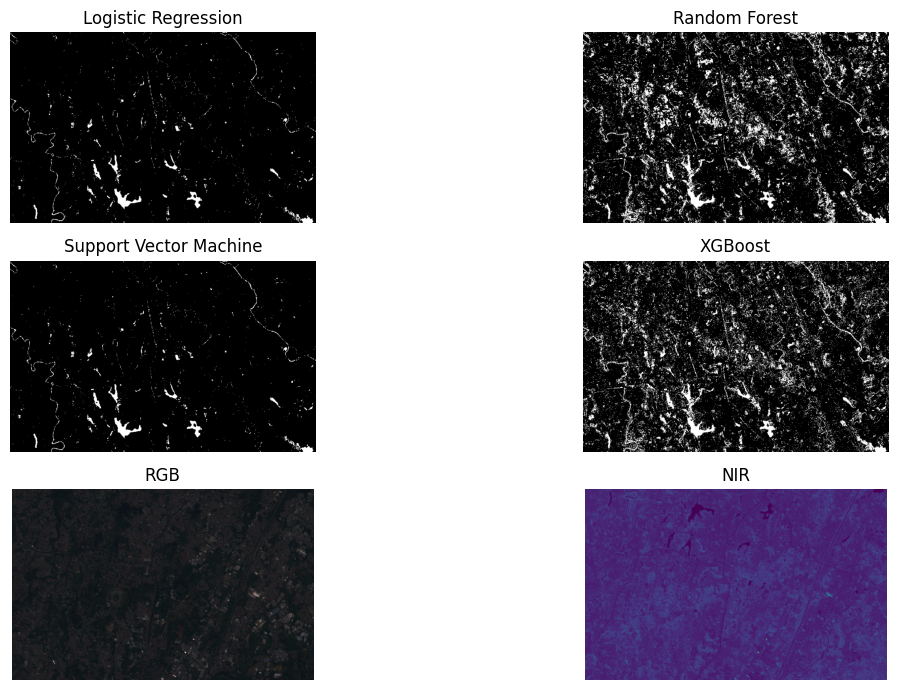

In [65]:
# Plot Results

image_paths = [
    r"H:\AfifBelajar\Water Bodies\pred_Logistic Regression.tif",
    r"H:\AfifBelajar\Water Bodies\pred_Random Forest.tif",
    r"H:\AfifBelajar\Water Bodies\pred_Support Vector Machine.tif",
    r"H:\AfifBelajar\Water Bodies\pred_XGBoost.tif",
    r"H:\AfifBelajar\Water Bodies\test_sat_w2w.tif"
]

with rasterio.open(image_paths[0]) as img1, \
     rasterio.open(image_paths[1]) as img2, \
     rasterio.open(image_paths[2]) as img3, \
     rasterio.open(image_paths[3]) as img4, \
     rasterio.open(image_paths[4]) as img5:

    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(14, 7))
    

    show(img1, ax=ax1, cmap='gray')
    show(img2, ax=ax2, cmap='gray')
    show(img3, ax=ax3, cmap='gray')
    show(img4, ax=ax4, cmap='gray')
    show(img5.read([3, 2, 1]), ax=ax5)  
    show(img5.read([4]), ax=ax6)         
    
    titles = [
        'Logistic Regression',
        'Random Forest',
        'Support Vector Machine',
        'XGBoost',
        'RGB',
        'NIR'
    ]
    
    for ax, title in zip([ax1, ax2, ax3, ax4, ax5, ax6], titles):
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()